In [38]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

Main file
- `train.csv` train dataset with the following columns:  
   - **id** - heartbeat sequence ID
   - **time** - time in ms (milliseconds)
   - **x** - R-R interval
   - **y** - anomalous feature mark
   
![R_R](images/r-r.png)

In [2]:
FILE_DATA = 'data/train.csv'

In [3]:
cs_master = pd.read_csv(FILE_DATA)

In [4]:
cs_master

id    time    x  y
0        1       0  800  0
1        1     780  780  0
2        1    1572  792  0
3        1    2392  820  0
4        1    3196  804  0
...    ...     ...  ... ..
60482  275  115360  552  0
60483  275  115912  552  0
60484  275  116464  552  0
60485  275  117020  556  0
60486  275  117572  552  0

[60487 rows x 4 columns]

In [5]:
cs_master['id'].value_counts().sort_index().describe()

count     229.000000
mean      264.135371
std       412.582574
min        32.000000
25%       100.000000
50%       151.000000
75%       219.000000
max      3661.000000
Name: id, dtype: float64

In [6]:
# creating the dict of sequences
cs_series = pd.DataFrame({'id':cs_master['id'].value_counts().sort_index().index, 'ser':''})

In [7]:
cs_master.loc[cs_master.id==cs_series['id'][1]]

id    time    x  y
1870   2       0  772  0
1871   2     132  132  0
1872   2     764  632  0
1873   2    1580  816  0
1874   2    2388  808  0
...   ..     ...  ... ..
2091   2  171960  784  1
2092   2  172736  776  1
2093   2  173508  772  0
2094   2  174288  780  0
2095   2  175044  756  0

[226 rows x 4 columns]

In [8]:
# filling the dict with measurement series
for key in cs_series.index:
    cs_series['ser'][key] = cs_master.loc[cs_master.id==cs_series['id'][key]]
# going to be a lot of warnings
# <ipython-input-25-32d300e09158>:3: SettingWithCopyWarning: 
# A value is trying to be set on a copy of a slice from a DataFrame

In [9]:
cs_series

id                                                ser
0      1        id     time    x  y
0      1        0  8...
1      2        id    time    x  y
1870   2       0  772...
2      3        id   time    x  y
2096   3      0  760  ...
3      4        id    time    x  y
2201   4       0  788...
4      5        id    time    x  y
2336   5       0  764...
..   ...                                                ...
224  270          id    time    x  y
59763  270       0 ...
225  271          id   time    x  y
59929  271      0  6...
226  272          id   time    x  y
60070  272      0  5...
227  273          id   time     x  y
60183  273      0  ...
228  275          id    time    x  y
60287  275       0 ...

[229 rows x 2 columns]

In [11]:
# value normalisation
# x_scaled - MinMaxScaler
# x_rscaled - RobustScaler

from sklearn import preprocessing
robust_scaler = preprocessing.RobustScaler()
min_max_scaler = preprocessing.MinMaxScaler()

for key in cs_series.index:
    df = cs_series['ser'][key]
    df['x_scaled'] = min_max_scaler.fit_transform(df[['x']])
    df['x_rscaled'] = robust_scaler.fit_transform(df[['x']])
    cs_series['ser'][key] = df

In [12]:
cs_series

id                                                ser
0      1        id     time    x  y  x_scaled  x_rscaled...
1      2        id    time    x  y  x_scaled  x_rscaled
...
2      3        id   time    x  y  x_scaled  x_rscaled
2...
3      4        id    time    x  y  x_scaled  x_rscaled
...
4      5        id    time    x  y  x_scaled  x_rscaled
...
..   ...                                                ...
224  270          id    time    x  y  x_scaled  x_rscale...
225  271          id   time    x  y  x_scaled  x_rscaled...
226  272          id   time    x  y  x_scaled  x_rscaled...
227  273          id   time     x  y  x_scaled  x_rscale...
228  275          id    time    x  y  x_scaled  x_rscale...

[229 rows x 2 columns]

In [13]:
import seaborn as sns

<AxesSubplot:xlabel='x_scaled', ylabel='Density'>

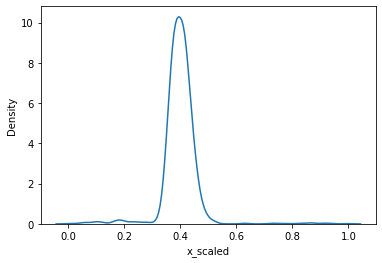

In [14]:
sns.kdeplot(x=cs_series.ser[0].x_scaled, legend=False)

In [15]:
cs_series.ser[1].describe()

id           time           x           y    x_scaled   x_rscaled
count  226.0     226.000000  226.000000  226.000000  226.000000  226.000000
mean     2.0   86997.150442  777.946903    0.163717    0.854427   -0.073325
std      0.0   51008.529374   52.730230    0.370840    0.069749    1.883223
min      2.0       0.000000  132.000000    0.000000    0.000000  -23.142857
25%      2.0   43316.000000  768.000000    0.000000    0.841270   -0.428571
50%      2.0   86784.000000  780.000000    0.000000    0.857143    0.000000
75%      2.0  130622.000000  796.000000    0.000000    0.878307    0.571429
max      2.0  175044.000000  888.000000    1.000000    1.000000    3.857143

In [16]:
# filling the dict
cs_series['count']=0 # measurement count
cs_series['count_mark']=0 # count of anomalies
cs_series['count_norm']=0 # count of normal results


cs_series['all_mean']=0 # total mean
cs_series['all_min']=0 # total min
cs_series['all_max']=0 # total max

cs_series['mark_mean']=0 # anomalous mean
cs_series['mark_min']=0 # anomalous min
cs_series['mark_max']=0 # anomalous max

cs_series['norm_mean']=0 # normal mean
cs_series['norm_min']=0 # normal min
cs_series['norm_max']=0 # normal max

for key in cs_series.index:
    ss=cs_series.ser[key]
    desc_mark = ss.loc[ss.y > 0 ].describe()
    desc_norm = ss.loc[ss.y ==0 ].describe()
    desc = ss.describe()
    cs_series['count'][key] = desc['x']['count']
    cs_series['all_mean'][key] = desc['x']['mean']
    cs_series['all_min'][key] = desc['x']['min']
    cs_series['all_max'][key] = desc['x']['max']

    cs_series['count_mark'][key] = desc_mark['x']['count']
    cs_series['mark_mean'][key] = desc_mark['x']['mean']
    cs_series['mark_min'][key] = desc_mark['x']['min']
    cs_series['mark_max'][key] = desc_mark['x']['max']
    
    cs_series['count_norm'][key] = desc_norm['x']['count']
    cs_series['norm_mean'][key] = desc_norm['x']['mean']
    cs_series['norm_min'][key] = desc_norm['x']['min']
    cs_series['norm_max'][key] = desc_norm['x']['max']


    

In [17]:
cs_series

id                                                ser  count  \
0      1        id     time    x  y  x_scaled  x_rscaled...   1870   
1      2        id    time    x  y  x_scaled  x_rscaled
...    226   
2      3        id   time    x  y  x_scaled  x_rscaled
2...    105   
3      4        id    time    x  y  x_scaled  x_rscaled
...    135   
4      5        id    time    x  y  x_scaled  x_rscaled
...    189   
..   ...                                                ...    ...   
224  270          id    time    x  y  x_scaled  x_rscale...    166   
225  271          id   time    x  y  x_scaled  x_rscaled...    141   
226  272          id   time    x  y  x_scaled  x_rscaled...    113   
227  273          id   time     x  y  x_scaled  x_rscale...    104   
228  275          id    time    x  y  x_scaled  x_rscale...    200   

     count_mark  count_norm  all_mean  all_min  all_max  mark_mean  mark_min  \
0            39        1831       747       20     1844        737       664   
1            37         189       777      132      888        781       704   
2            40          65       787      704      852        780       704   
3            39          96       787      724      844        777       724   
4            41         148       784      724      868        786       724   
..          ...         ...       ...      ...      ...        ...       ...   
224          36         130       625      520     1280        612       544   
225          36         105       637      512     1256        622       556   
226          42          71       588      508      648        589       508   
227          61          43       626      560     1192        621       560   
228          43         157       590      500     1220        575       500   

     mark_max  norm_mean  norm_min  norm_max  
0         828        747        20      1844  
1         852        777       132       888  
2         852        792       740       844  
3         836        791       756       844  
4         852        784       740       868  
..        ...        ...       ...       ...  
224       684        629       520      1280  
225       708        642       512      1256  
226       648        588       512       640  
227       680        634       588      1192  
228       632        595       504      1220  

[229 rows x 14 columns]

In [18]:
cs_series.sort_values(by='count').head(100)

id                                                ser  count  \
108  126          id   time    x  y  x_scaled  x_rscaled...     32   
48    58         id   time     x  y  x_scaled  x_rscaled...     41   
27    34        id   time    x  y  x_scaled  x_rscaled
9...     41   
115  133          id   time     x  y  x_scaled  x_rscale...     47   
196  235          id   time    x  y  x_scaled  x_rscaled...     51   
..   ...                                                ...    ...   
100  118          id   time    x  y  x_scaled  x_rscaled...    135   
3      4        id    time    x  y  x_scaled  x_rscaled
...    135   
36    44         id   time    x  y  x_scaled  x_rscaled
...    135   
71    82         id   time     x  y  x_scaled  x_rscaled...    135   
138  161          id    time    x  y  x_scaled  x_rscale...    136   

     count_mark  count_norm  all_mean  all_min  all_max  mark_mean  mark_min  \
108          20          12       637      588      700        638       588   
48           28          13       552      488     1096        539       488   
27           22          19       645      592      704        646       592   
115          25          22       616      548     1216        604       548   
196          35          16       906      844      972        905       848   
..          ...         ...       ...      ...      ...        ...       ...   
100          31         104       663      592     1376        651       596   
3            39          96       787      724      844        777       724   
36           38          97       644      572      708        644       584   
71           31         104       531      156     1588        528       472   
138          32         104       804      116      912        831       760   

     mark_max  norm_mean  norm_min  norm_max  
108       692        636       616       700  
48        596        579       524      1096  
27        704        644       592       704  
115       656        631       548      1216  
196       972        908       844       964  
..        ...        ...       ...       ...  
100       704        666       592      1376  
3         836        791       756       844  
36        700        645       572       708  
71        600        531       156      1588  
138       900        796       116       912  

[100 rows x 14 columns]

In [19]:
cs_series.describe()

id        count  count_mark   count_norm    all_mean  \
count  229.000000   229.000000  229.000000   229.000000  229.000000   
mean   135.903930   264.135371   39.131004   225.004367  640.794760   
std     79.519662   412.582574   10.382608   414.427617   92.018671   
min      1.000000    32.000000   18.000000    12.000000  289.000000   
25%     67.000000   100.000000   32.000000    55.000000  581.000000   
50%    132.000000   151.000000   37.000000   106.000000  637.000000   
75%    206.000000   219.000000   44.000000   179.000000  678.000000   
max    275.000000  3661.000000   81.000000  3635.000000  906.000000   

          all_min       all_max   mark_mean    mark_min     mark_max  \
count  229.000000    229.000000  229.000000  229.000000   229.000000   
mean   350.541485   1566.043668  655.877729  592.174672   720.262009   
std    235.501377   2800.827913  102.810134   97.478225   108.901377   
min     12.000000    580.000000  522.000000  464.000000   576.000000   
25%     92.000000    848.000000  579.000000  520.000000   636.000000   
50%    476.000000   1272.000000  635.000000  572.000000   700.000000   
75%    548.000000   1508.000000  702.000000  636.000000   764.000000   
max    844.000000  40900.000000  937.000000  860.000000  1024.000000   

        norm_mean    norm_min      norm_max  
count  229.000000  229.000000    229.000000  
mean   641.908297  360.445415   1560.698690  
std     91.719229  244.123410   2802.594074  
min    282.000000   12.000000    552.000000  
25%    580.000000   92.000000    844.000000  
50%    636.000000  476.000000   1272.000000  
75%    691.000000  568.000000   1508.000000  
max    908.000000  844.000000  40900.000000

In [20]:
cs_series.ser[0]

id     time    x  y  x_scaled  x_rscaled
0      1        0  800  0  0.427632   0.590909
1      1      780  780  0  0.416667   0.363636
2      1     1572  792  0  0.423246   0.500000
3      1     2392  820  0  0.438596   0.818182
4      1     3196  804  0  0.429825   0.636364
...   ..      ...  ... ..       ...        ...
1865   1  1395312  640  0  0.339912  -1.227273
1866   1  1395684  372  0  0.192982  -4.272727
1867   1  1395756   72  0  0.028509  -7.681818
1868   1  1396596  840  0  0.449561   1.045455
1869   1  1397264  668  0  0.355263  -0.909091

[1870 rows x 6 columns]

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [22]:
def plot_wide(df_arr, key, isMarked=True):
    figure(figsize=(20,2))
    df=df_arr[key]
    if isMarked:
#         df = data.drop(data[data['Column_3'] == '1'].index[1000:])
        df = df[df['y'] > 0]
        plt.plot( df.x_rscaled)
    else:
        plt.plot(df.time, df.x_rscaled)
        plt.plot(df.time, df.y*5)
    plt.show()

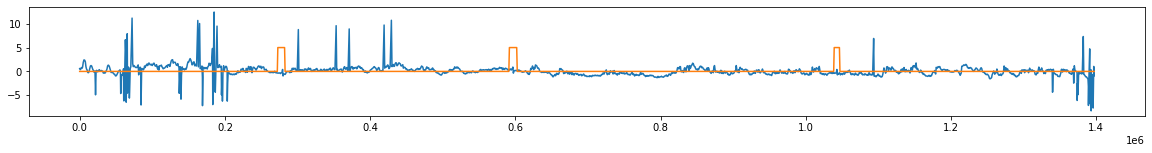

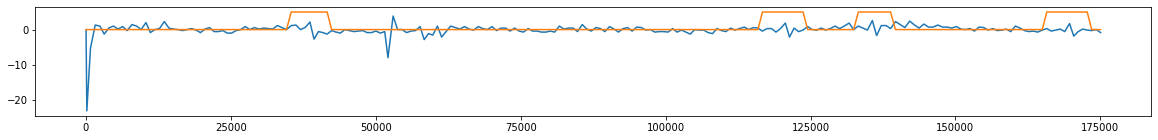

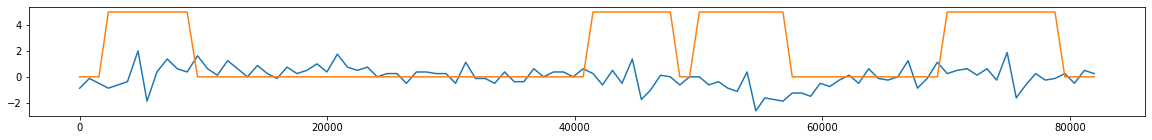

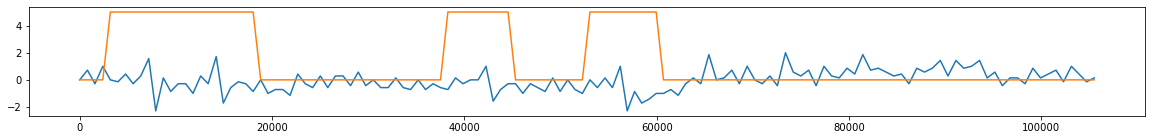

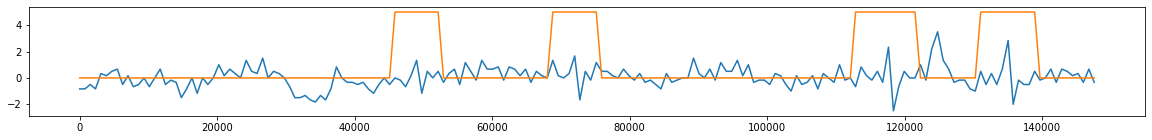

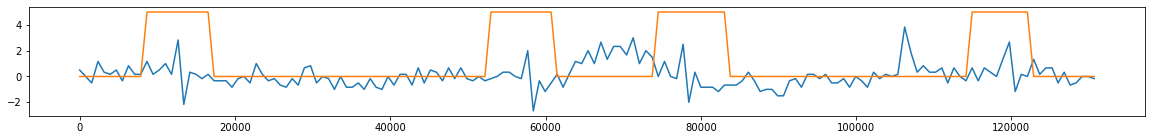

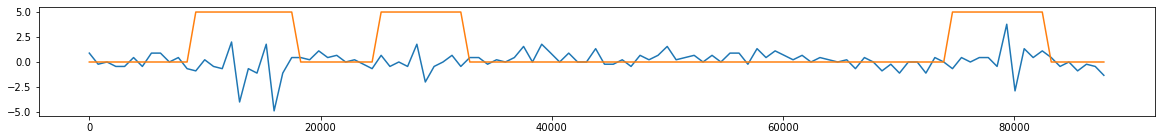

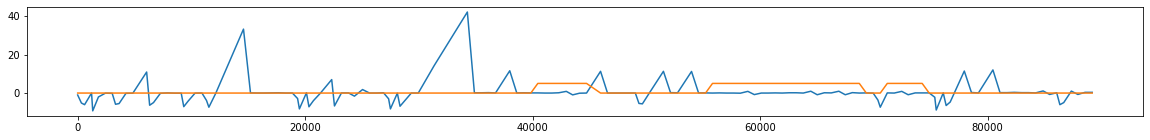

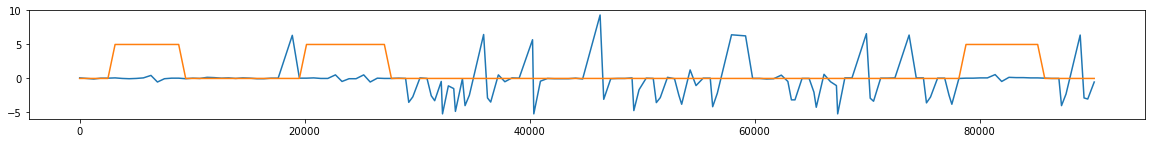

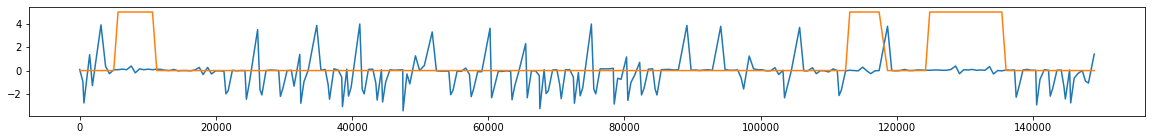

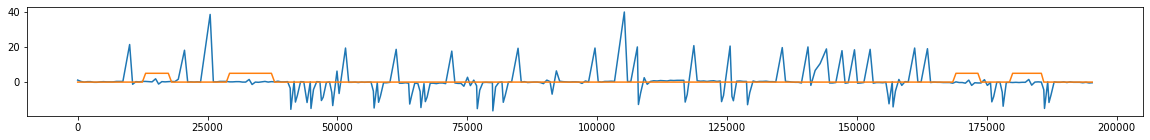

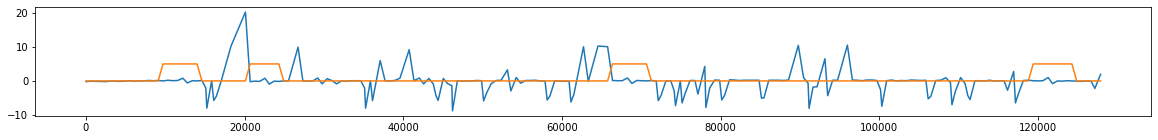

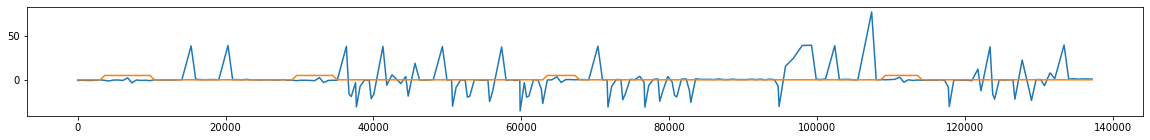

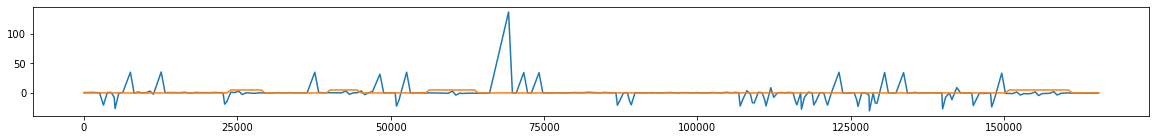

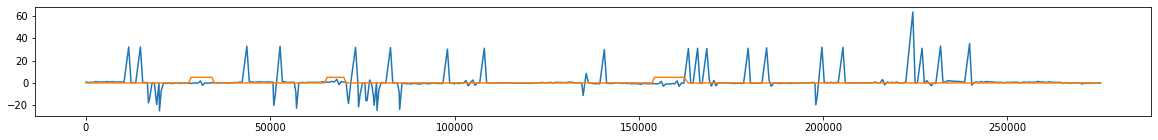

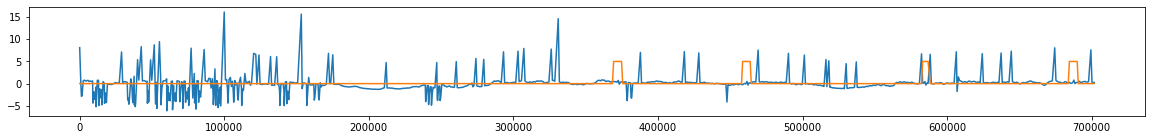

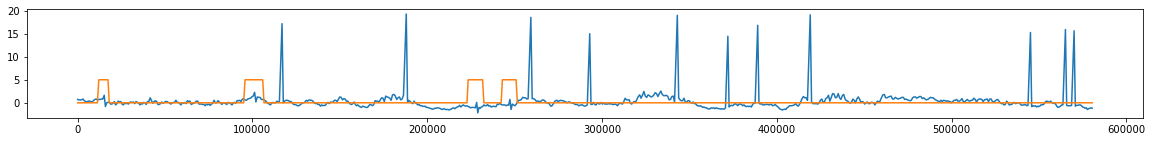

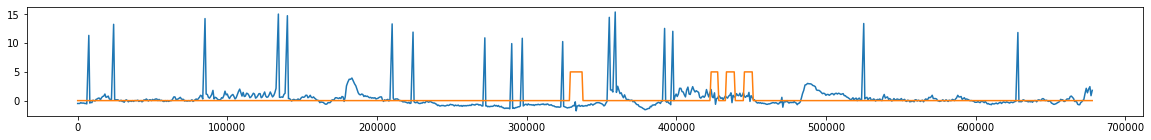

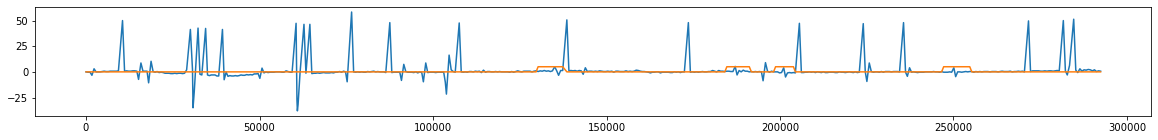

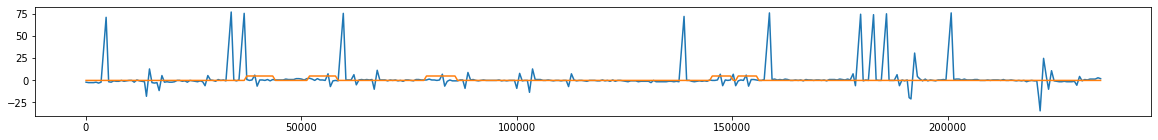

In [23]:
for key in range(0,20):
    plot_wide(cs_series.ser,key, isMarked=False)

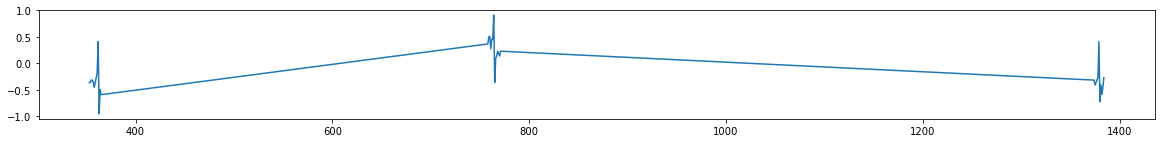

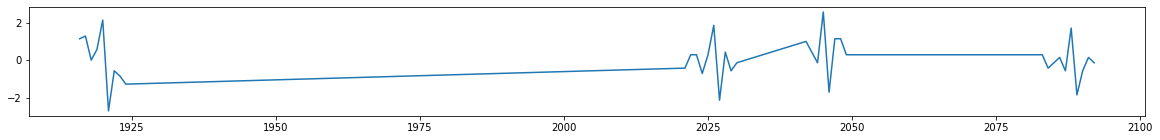

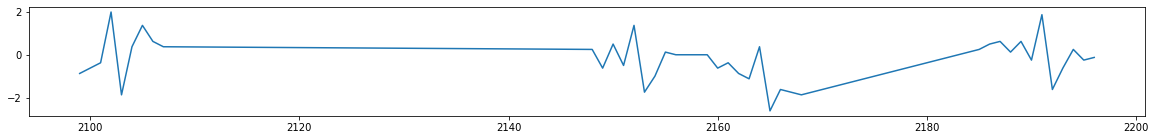

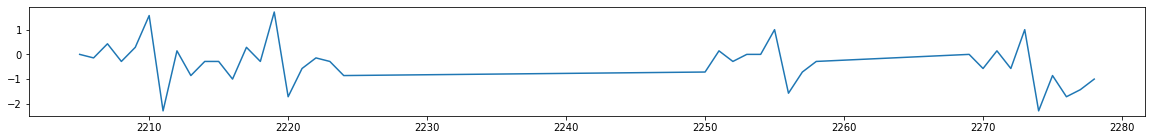

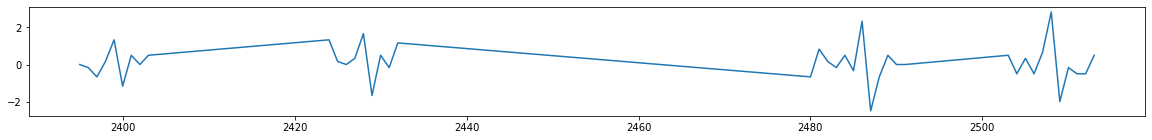

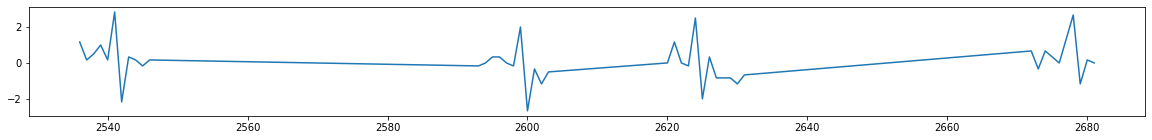

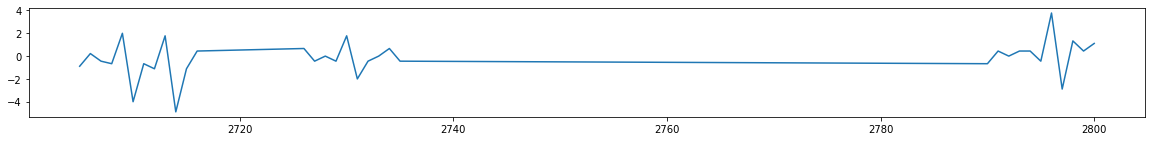

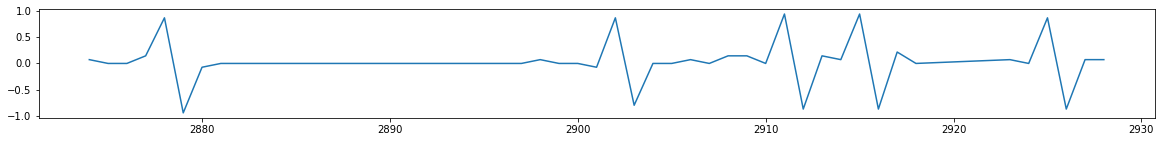

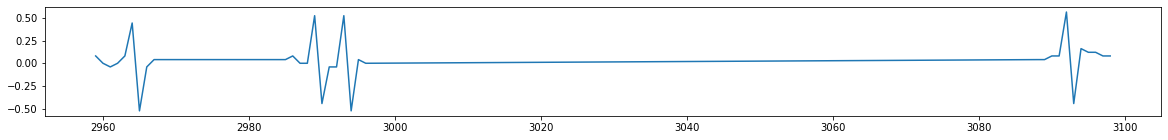

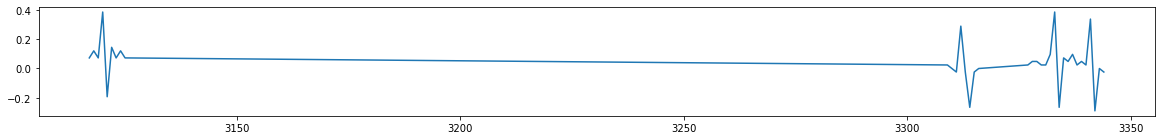

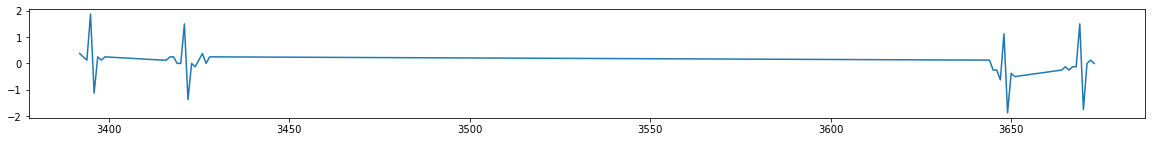

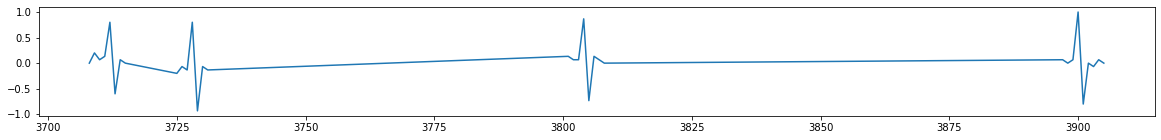

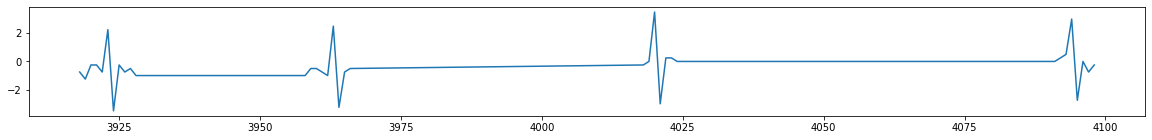

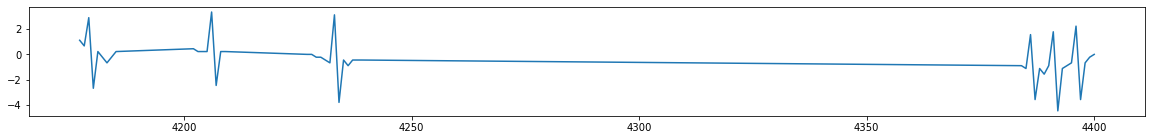

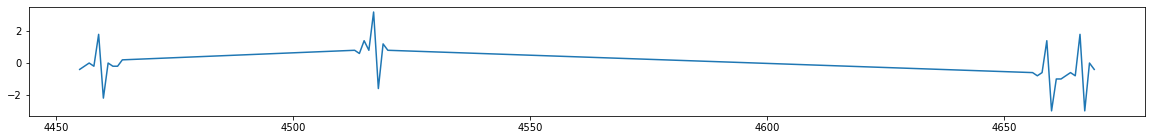

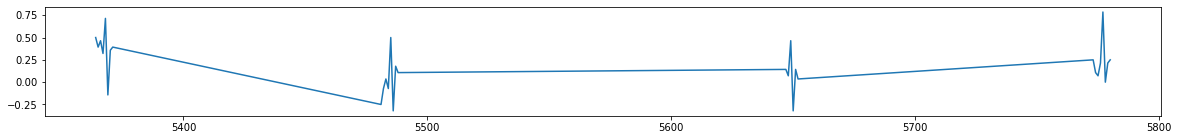

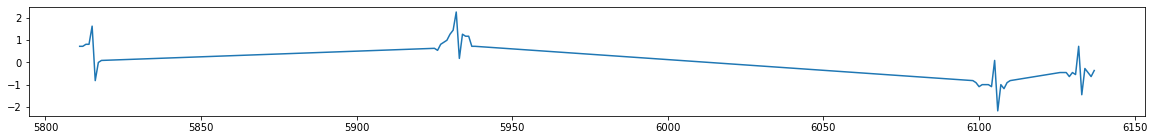

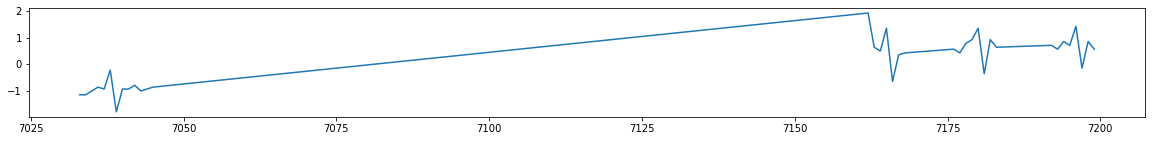

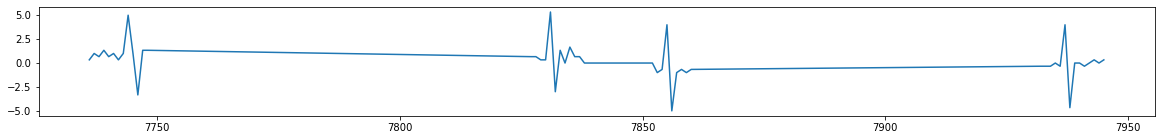

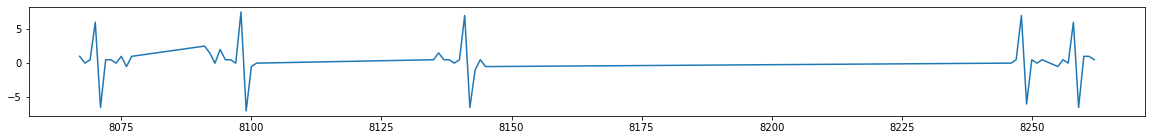

In [24]:
for key in range(0,20):
    plot_wide(cs_series.ser,key)

In [25]:
df=cs_series.ser[0]

In [26]:
df

id     time    x  y  x_scaled  x_rscaled
0      1        0  800  0  0.427632   0.590909
1      1      780  780  0  0.416667   0.363636
2      1     1572  792  0  0.423246   0.500000
3      1     2392  820  0  0.438596   0.818182
4      1     3196  804  0  0.429825   0.636364
...   ..      ...  ... ..       ...        ...
1865   1  1395312  640  0  0.339912  -1.227273
1866   1  1395684  372  0  0.192982  -4.272727
1867   1  1395756   72  0  0.028509  -7.681818
1868   1  1396596  840  0  0.449561   1.045455
1869   1  1397264  668  0  0.355263  -0.909091

[1870 rows x 6 columns]

## Interval interpretation

![R_R](images/spike.jpeg)

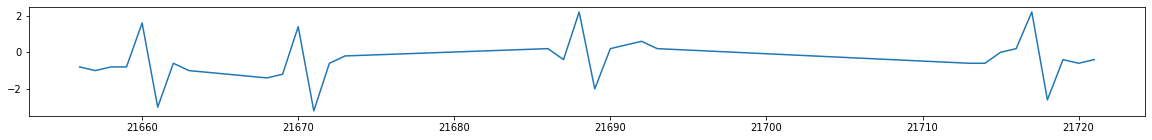

In [27]:
plot_wide(cs_series.ser,100)

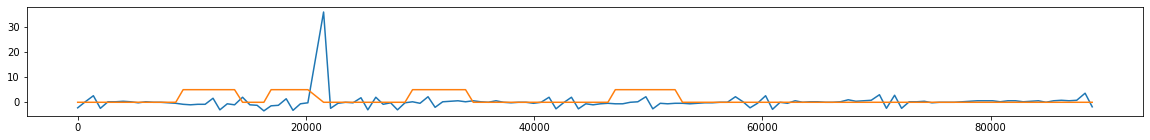

In [28]:
plot_wide(cs_series.ser,100, isMarked=False)

In [29]:
pd.set_option('display.max_rows', 500)
cs_series.ser[100]

id   time     x  y  x_scaled  x_rscaled
21642  118      0   616  0  0.030612       -2.2
21643  118    664   664  0  0.091837        0.2
21644  118   1376   712  0  0.153061        2.6
21645  118   1988   612  0  0.025510       -2.4
21646  118   2652   664  0  0.091837        0.2
21647  118   3316   664  0  0.091837        0.2
21648  118   3984   668  0  0.096939        0.4
21649  118   4648   664  0  0.091837        0.2
21650  118   5304   656  0  0.081633       -0.2
21651  118   5968   664  0  0.091837        0.2
21652  118   6628   660  0  0.086735        0.0
21653  118   7288   660  0  0.086735        0.0
21654  118   7944   656  0  0.081633       -0.2
21655  118   8596   652  0  0.076531       -0.4
21656  118   9240   644  1  0.066327       -0.8
21657  118   9880   640  1  0.061224       -1.0
21658  118  10524   644  1  0.066327       -0.8
21659  118  11168   644  1  0.066327       -0.8
21660  118  11860   692  1  0.127551        1.6
21661  118  12460   600  1  0.010204       -3.0
21662  118  13108   648  1  0.071429       -0.6
21663  118  13748   640  1  0.061224       -1.0
21664  118  14448   700  0  0.137755        2.0
21665  118  15088   640  0  0.061224       -1.0
21666  118  15724   636  0  0.056122       -1.2
21667  118  16316   592  0  0.000000       -3.4
21668  118  16948   632  1  0.051020       -1.4
21669  118  17584   636  1  0.056122       -1.2
21670  118  18272   688  1  0.122449        1.4
21671  118  18868   596  1  0.005102       -3.2
21672  118  19516   648  1  0.071429       -0.6
21673  118  20172   656  1  0.081633       -0.2
21674  118  21548  1376  0  1.000000       35.8
21675  118  22160   612  0  0.025510       -2.4
21676  118  22812   652  0  0.076531       -0.4
21677  118  23472   660  0  0.086735        0.0
21678  118  24128   656  0  0.081633       -0.2
21679  118  24824   696  0  0.132653        1.8
21680  118  25424   600  0  0.010204       -3.0
21681  118  26124   700  0  0.137755        2.0
21682  118  26768   644  0  0.066327       -0.8
21683  118  27424   656  0  0.081633       -0.2
21684  118  28024   600  0  0.010204       -3.0
21685  118  28680   656  0  0.081633       -0.2
21686  118  29344   664  1  0.091837        0.2
21687  118  29996   652  1  0.076531       -0.4
21688  118  30700   704  1  0.142857        2.2
21689  118  31320   620  1  0.035714       -2.0
21690  118  31984   664  1  0.091837        0.2
21691  118  32652   668  1  0.096939        0.4
21692  118  33324   672  1  0.102041        0.6
21693  118  33988   664  1  0.091837        0.2
21694  118  34660   672  0  0.102041        0.6
21695  118  35324   664  0  0.091837        0.2
21696  118  35984   660  0  0.086735        0.0
21697  118  36656   672  0  0.102041        0.6
21698  118  37316   660  0  0.086735        0.0
21699  118  37972   656  0  0.081633       -0.2
21700  118  38632   660  0  0.086735        0.0
21701  118  39292   660  0  0.086735        0.0
21702  118  39944   652  0  0.076531       -0.4
21703  118  40604   660  0  0.086735        0.0
21704  118  41304   700  0  0.137755        2.0
21705  118  41912   608  0  0.020408       -2.6
21706  118  42568   656  0  0.081633       -0.2
21707  118  43268   700  0  0.137755        2.0
21708  118  43876   608  0  0.020408       -2.6
21709  118  44524   648  0  0.071429       -0.6
21710  118  45164   640  0  0.061224       -1.0
21711  118  45812   648  0  0.071429       -0.6
21712  118  46464   652  0  0.076531       -0.4
21713  118  47112   648  1  0.071429       -0.6
21714  118  47760   648  1  0.071429       -0.6
21715  118  48420   660  1  0.086735        0.0
21716  118  49084   664  1  0.091837        0.2
21717  118  49788   704  1  0.142857        2.2
21718  118  50396   608  1  0.020408       -2.6
21719  118  51048   652  1  0.076531       -0.4
21720  118  51696   648  1  0.071429       -0.6
21721  118  52348   652  1  0.076531       -0.4
21722  118  53000   652  0  0.076531       -0.4
21723  118  53648   648  0  0.071429       -0.6
21724  118  54300   652 

In [30]:
cs_series.loc[[100]]

id                                                ser  count  \
100  118          id   time     x  y  x_scaled  x_rscale...    135   

     count_mark  count_norm  all_mean  all_min  all_max  mark_mean  mark_min  \
100          31         104       663      592     1376        651       596   

     mark_max  norm_mean  norm_min  norm_max  
100       704        666       592      1376

In [140]:
df = cs_master.drop(columns='time')

for sfx in range(10):
    if sfx < 5:
        column_name = 'x_minus_' + str(5 - sfx)
    else:
        column_name = 'x_plus_' + str(sfx - 4)
    df[column_name] = 0


for itm in cs_master['id'].unique():
    tmp = df.loc[df['id']==itm]
    tmp.loc[(tmp['x'] < np.quantile(tmp['x'], 0.1)) | (tmp['x'] > np.quantile(tmp['x'], 0.9)), ['x']] = tmp['x'].median()
    tmp['x'] = robust_scaler.fit_transform(tmp[['x']])
    
    for sfx in range(10):
        if sfx < 5:
            column_name = 'x_minus_' + str(5 - sfx)
        else:
            column_name = 'x_plus_' + str(sfx - 4)
        tmp[column_name] = 0
        for idx in tmp.index:
            if sfx < 5 and idx - tmp.index[0] >= 5 - sfx:
                tmp[column_name].loc[idx] = tmp['x'].loc[idx - 5 + sfx]
            elif sfx >= 5 and idx + sfx - 4 <= tmp.index[-1]:
                tmp[column_name].loc[idx] = tmp['x'].loc[idx + sfx - 4]
    df.loc[df['id']==itm] = tmp
df

id         x  y  x_minus_5  x_minus_4  x_minus_3  x_minus_2  \
0        1  0.928571  0   0.000000   0.000000   0.000000   0.000000   
1        1  0.571429  0   0.000000   0.000000   0.000000   0.000000   
2        1  0.785714  0   0.000000   0.000000   0.000000   0.928571   
3        1  1.285714  0   0.000000   0.000000   0.928571   0.571429   
4        1  1.000000  0   0.000000   0.928571   0.571429   0.785714   
...    ...       ... ..        ...        ...        ...        ...   
60482  275 -2.000000  0  -1.333333  -2.000000  -1.333333   0.000000   
60483  275 -2.000000  0  -2.000000  -1.333333   0.000000   0.000000   
60484  275 -2.000000  0  -1.333333   0.000000   0.000000  -2.000000   
60485  275 -1.666667  0   0.000000   0.000000  -2.000000  -2.000000   
60486  275 -2.000000  0   0.000000  -2.000000  -2.000000  -2.000000   

       x_minus_1  x_plus_1  x_plus_2  x_plus_3  x_plus_4  x_plus_5  
0       0.000000  0.571429  0.785714  1.285714  1.000000  1.428571  
1       0.928571  0.785714  1.285714  1.000000  1.428571  0.000000  
2       0.571429  1.285714  1.000000  1.428571  0.000000  0.000000  
3       0.785714  1.000000  1.428571  0.000000  0.000000  0.000000  
4       1.285714  1.428571  0.000000  0.000000  0.000000  0.000000  
...          ...       ...       ...       ...       ...       ...  
60482   0.000000 -2.000000 -2.000000 -1.666667 -2.000000  0.000000  
60483  -2.000000 -2.000000 -1.666667 -2.000000  0.000000  0.000000  
60484  -2.000000 -1.666667 -2.000000  0.000000  0.000000  0.000000  
60485  -2.000000 -2.000000  0.000000  0.000000  0.000000  0.000000  
60486  -1.666667  0.000000  0.000000  0.000000  0.000000  0.000000  

[60487 rows x 13 columns]

In [185]:
X = df.drop(columns=['id', 'y'])
y = df['y']

In [186]:
X

x  x_minus_5  x_minus_4  x_minus_3  x_minus_2  x_minus_1  \
0      0.928571   0.000000   0.000000   0.000000   0.000000   0.000000   
1      0.571429   0.000000   0.000000   0.000000   0.000000   0.928571   
2      0.785714   0.000000   0.000000   0.000000   0.928571   0.571429   
3      1.285714   0.000000   0.000000   0.928571   0.571429   0.785714   
4      1.000000   0.000000   0.928571   0.571429   0.785714   1.285714   
...         ...        ...        ...        ...        ...        ...   
60482 -2.000000  -1.333333  -2.000000  -1.333333   0.000000   0.000000   
60483 -2.000000  -2.000000  -1.333333   0.000000   0.000000  -2.000000   
60484 -2.000000  -1.333333   0.000000   0.000000  -2.000000  -2.000000   
60485 -1.666667   0.000000   0.000000  -2.000000  -2.000000  -2.000000   
60486 -2.000000   0.000000  -2.000000  -2.000000  -2.000000  -1.666667   

       x_plus_1  x_plus_2  x_plus_3  x_plus_4  x_plus_5  
0      0.571429  0.785714  1.285714  1.000000  1.428571  
1      0.785714  1.285714  1.000000  1.428571  0.000000  
2      1.285714  1.000000  1.428571  0.000000  0.000000  
3      1.000000  1.428571  0.000000  0.000000  0.000000  
4      1.428571  0.000000  0.000000  0.000000  0.000000  
...         ...       ...       ...       ...       ...  
60482 -2.000000 -2.000000 -1.666667 -2.000000  0.000000  
60483 -2.000000 -1.666667 -2.000000  0.000000  0.000000  
60484 -1.666667 -2.000000  0.000000  0.000000  0.000000  
60485 -2.000000  0.000000  0.000000  0.000000  0.000000  
60486  0.000000  0.000000  0.000000  0.000000  0.000000  

[60487 rows x 11 columns]

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

In [143]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                      shuffle=True, 
                                                      stratify=y, 
                                                      random_state=42)

In [122]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [123]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [154]:
clf = DecisionTreeClassifier(
    max_depth=30, 
    random_state=42
)
clf.fit(X_train, y_train)

evaluate_preds(clf, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     36067
           1       0.97      0.84      0.90      6273

    accuracy                           0.97     42340
   macro avg       0.97      0.92      0.94     42340
weighted avg       0.97      0.97      0.97     42340

TEST

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     15459
           1       0.24      0.24      0.24      2688

    accuracy                           0.77     18147
   macro avg       0.55      0.55      0.55     18147
weighted avg       0.77      0.77      0.77     18147

CONFUSION MATRIX

col_0      0     1
y                 
0      13415  2044
1       2046   642


In [155]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

5.749561613263191

In [181]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'one_hot_max_size':15,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [182]:
import catboost as catb

In [183]:
final_model = catb.CatBoostClassifier(**frozen_params, iterations=100, max_depth=8)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

evaluate_preds(final_model, X_train, X_valid, y_train, y_valid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     36067
           1       0.33      0.80      0.47      6273

    accuracy                           0.73     42340
   macro avg       0.64      0.76      0.64     42340
weighted avg       0.86      0.73      0.77     42340

TEST

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     15459
           1       0.28      0.69      0.40      2688

    accuracy                           0.69     18147
   macro avg       0.61      0.69      0.60     18147
weighted avg       0.83      0.69      0.74     18147

CONFUSION MATRIX

col_0      0     1
y                 
0      10747  4712
1        827  1861


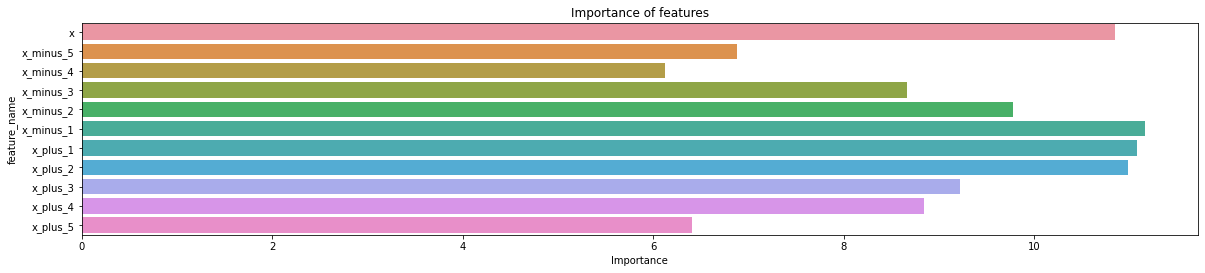

In [184]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
sns.barplot(feature_importances['importance'], feature_importances['feature_name'])
    
plt.xlabel('Importance')
plt.title('Importance of features')
plt.show()

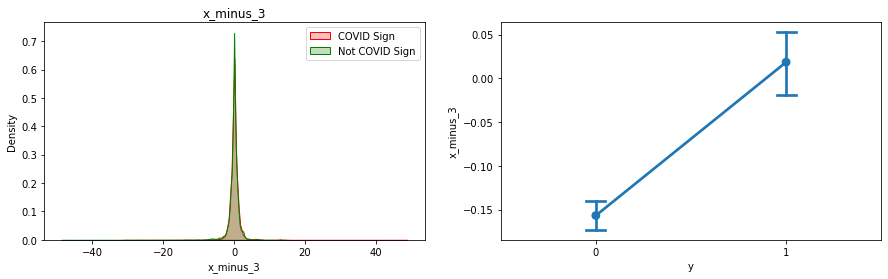

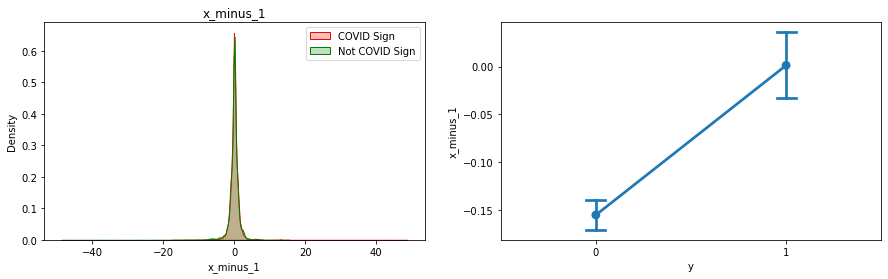

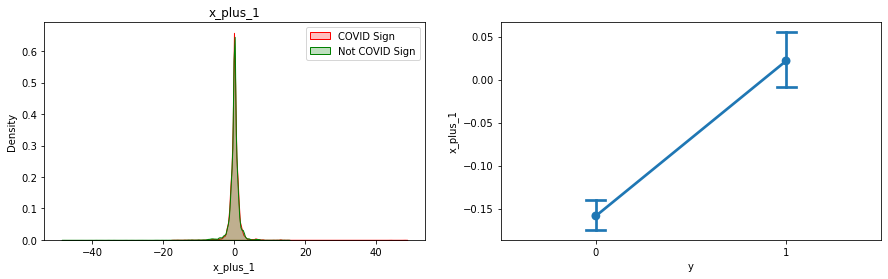

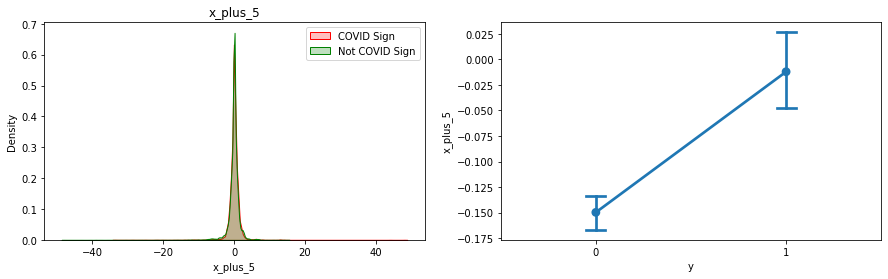

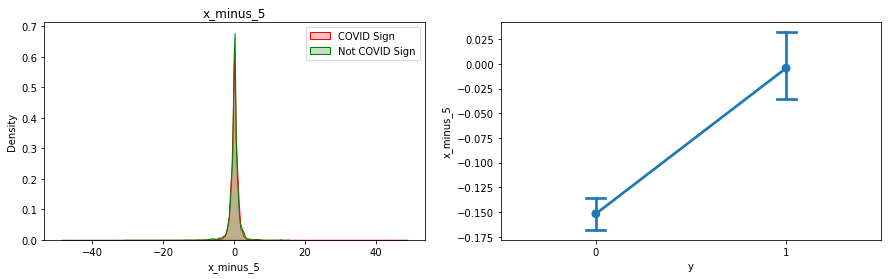

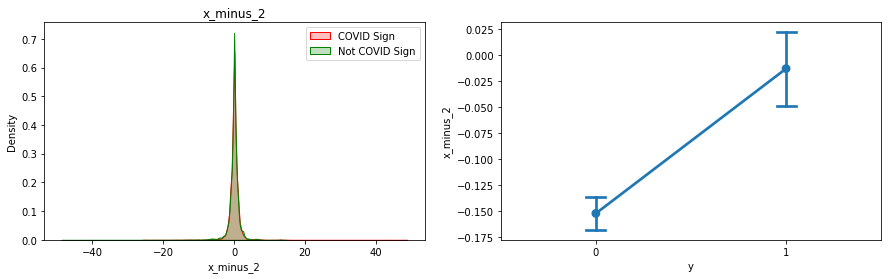

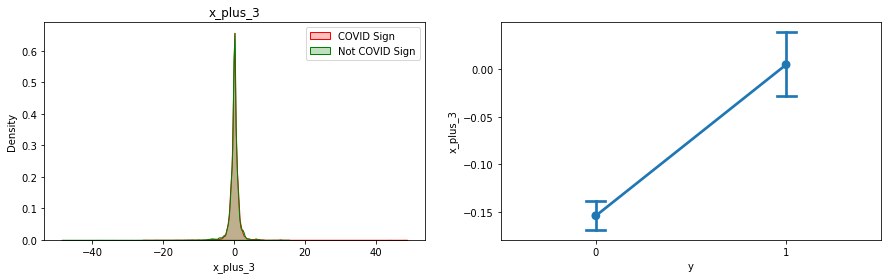

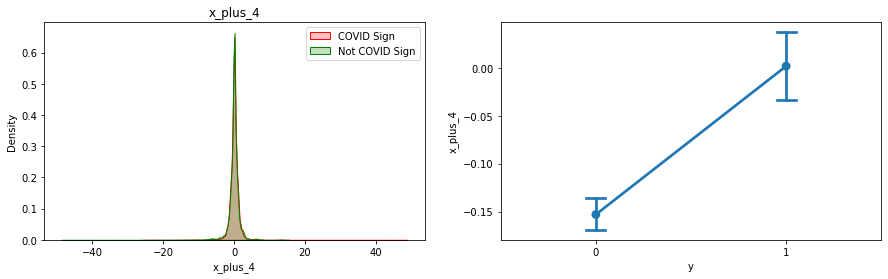

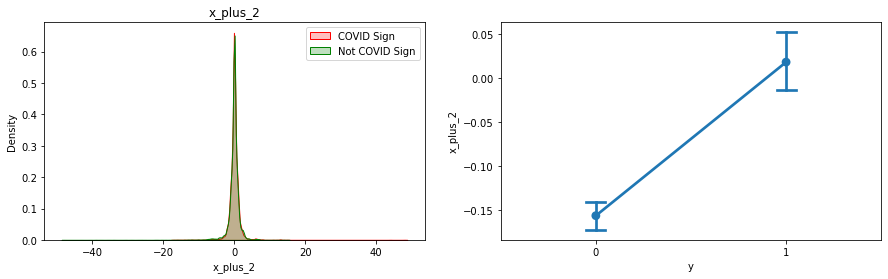

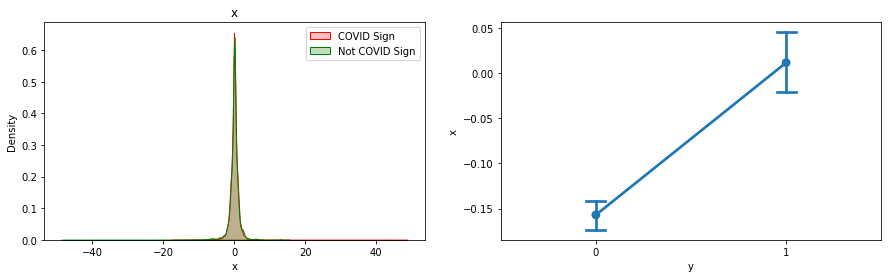

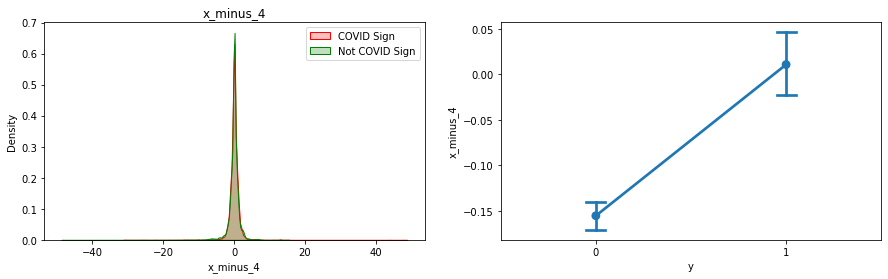

In [197]:
for column in set(df.columns) - {'id', 'y'}:
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    sns.kdeplot(df.loc[df['y'] == 1, column], shade=True, label='COVID Sign', color='r')
    sns.kdeplot(df.loc[df['y'] == 0, column], shade=True, label='Not COVID Sign', color='g')
    plt.legend()
    plt.title(column)
    plt.subplot(122)
    sns.pointplot(x=df['y'], y=df[column], capsize=.1)
    plt.show()

In [225]:
window_column = ['x', 'x_minus_5', 'x_minus_4', 'x_minus_3', 'x_minus_2', 'x_minus_1', 'x_plus_1', 'x_plus_2', 'x_plus_3', 'x_plus_4', 'x_plus_5']

for row in df.index:
    res = []
    for column in window_column:
        res.append(df.loc[[row]][column].values[0])
        res.sort()
    for idx in range(len(res)):
        df['x' + str(idx)].loc[[row]] = res[idx]
df

id         x  y  x_minus_5  x_minus_4  x_minus_3  x_minus_2  \
0        1  0.928571  0   0.000000   0.000000   0.000000   0.000000   
1        1  0.571429  0   0.000000   0.000000   0.000000   0.000000   
2        1  0.785714  0   0.000000   0.000000   0.000000   0.928571   
3        1  1.285714  0   0.000000   0.000000   0.928571   0.571429   
4        1  1.000000  0   0.000000   0.928571   0.571429   0.785714   
...    ...       ... ..        ...        ...        ...        ...   
60482  275 -2.000000  0  -1.333333  -2.000000  -1.333333   0.000000   
60483  275 -2.000000  0  -2.000000  -1.333333   0.000000   0.000000   
60484  275 -2.000000  0  -1.333333   0.000000   0.000000  -2.000000   
60485  275 -1.666667  0   0.000000   0.000000  -2.000000  -2.000000   
60486  275 -2.000000  0   0.000000  -2.000000  -2.000000  -2.000000   

       x_minus_1  x_plus_1  x_plus_2  ...   x1   x2   x3        x4        x5  \
0       0.000000  0.571429  0.785714  ...  0.0  0.0  0.0  0.000000  0.571429   
1       0.928571  0.785714  1.285714  ...  0.0  0.0  0.0  0.000000  0.571429   
2       0.571429  1.285714  1.000000  ...  0.0  0.0  0.0  0.000000  0.571429   
3       0.785714  1.000000  1.428571  ...  0.0  0.0  0.0  0.000000  0.571429   
4       1.285714  1.428571  0.000000  ...  0.0  0.0  0.0  0.000000  0.571429   
...          ...       ...       ...  ...  ...  ...  ...       ...       ...   
60482   0.000000 -2.000000 -2.000000  ... -2.0 -2.0 -2.0 -2.000000 -1.666667   
60483  -2.000000 -2.000000 -1.666667  ... -2.0 -2.0 -2.0 -2.000000 -1.666667   
60484  -2.000000 -1.666667 -2.000000  ... -2.0 -2.0 -2.0 -1.666667 -1.333333   
60485  -2.000000 -2.000000  0.000000  ... -2.0 -2.0 -2.0 -1.666667  0.000000   
60486  -1.666667  0.000000  0.000000  ... -2.0 -2.0 -2.0 -1.666667  0.000000   

             x6        x7   x8        x9       x10  
0      0.785714  0.928571  1.0  1.285714  1.428571  
1      0.785714  0.928571  1.0  1.285714  1.428571  
2      0.785714  0.928571  1.0  1.285714  1.428571  
3      0.785714  0.928571  1.0  1.285714  1.428571  
4      0.785714  0.928571  1.0  1.285714  1.428571  
...         ...       ...  ...       ...       ...  
60482 -1.333333 -1.333333  0.0  0.000000  0.000000  
60483 -1.333333  0.000000  0.0  0.000000  0.000000  
60484  0.000000  0.000000  0.0  0.000000  0.000000  
60485  0.000000  0.000000  0.0  0.000000  0.000000  
60486  0.000000  0.000000  0.0  0.000000  0.000000  

[60487 rows x 24 columns]

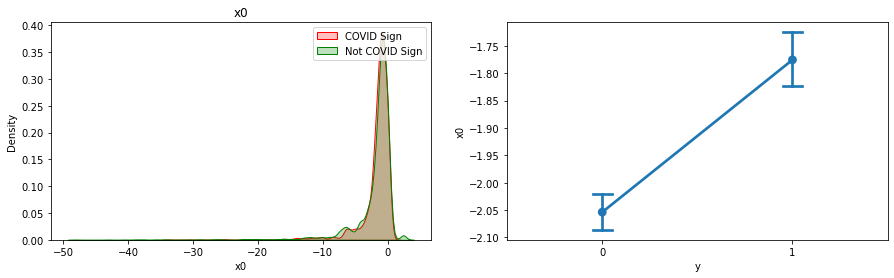

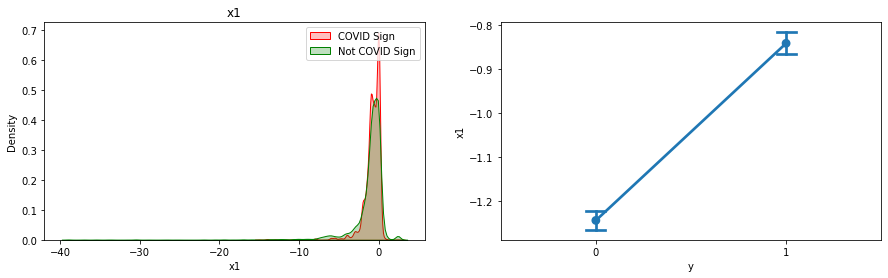

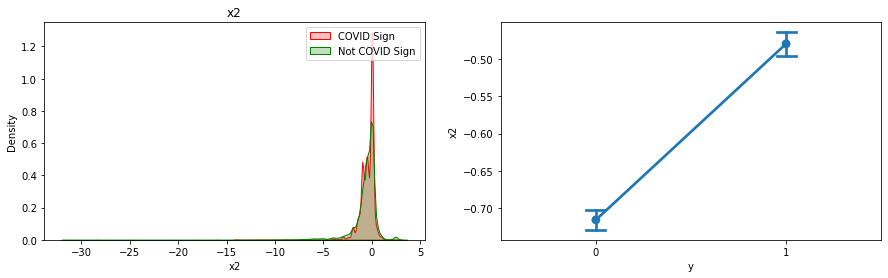

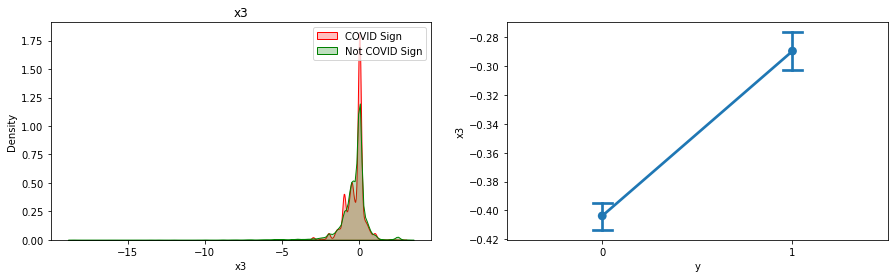

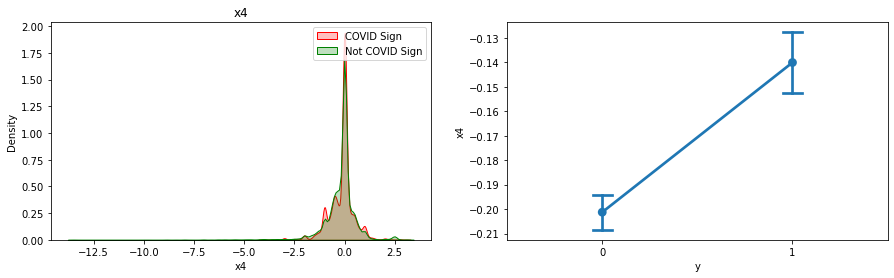

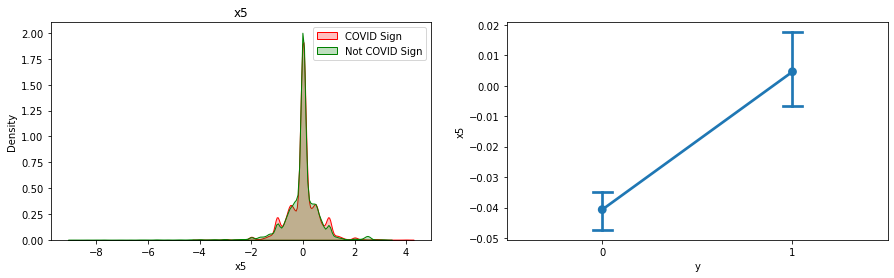

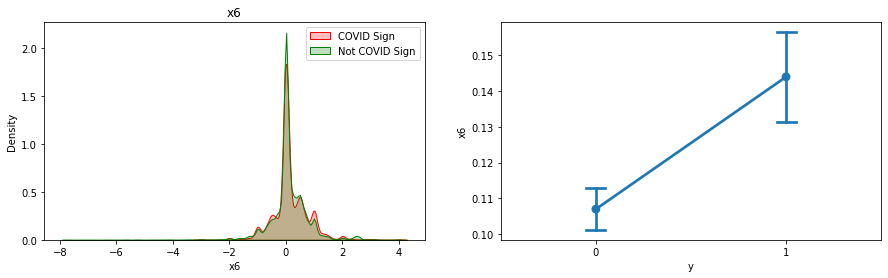

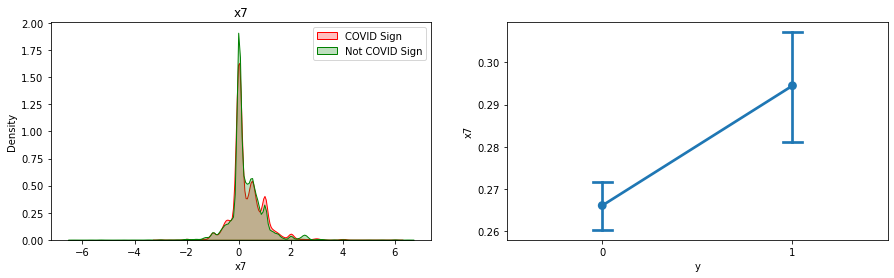

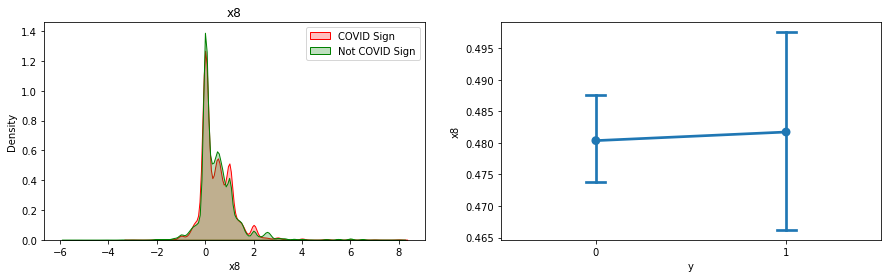

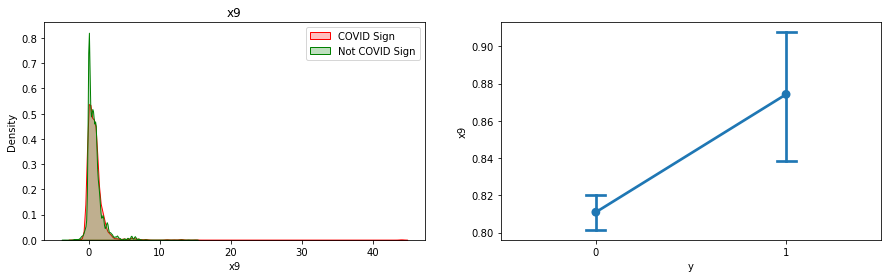

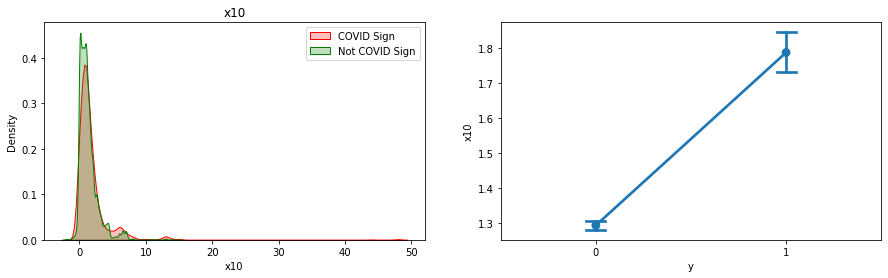

In [226]:
window_column_ranged = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
for column in window_column_ranged:
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    sns.kdeplot(df.loc[df['y'] == 1, column], shade=True, label='COVID Sign', color='r')
    sns.kdeplot(df.loc[df['y'] == 0, column], shade=True, label='Not COVID Sign', color='g')
    plt.legend()
    plt.title(column)
    plt.subplot(122)
    sns.pointplot(x=df['y'], y=df[column], capsize=.1)
    plt.show()

In [227]:
X = df.drop(columns=['id', 'y'])
y = df['y']

In [228]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                      shuffle=True, 
                                                      stratify=y, 
                                                      random_state=42)

In [232]:
catb_model2 = catb.CatBoostClassifier(**frozen_params, iterations=100, max_depth=9)
catb_model2.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

evaluate_preds(catb_model2, X_train, X_valid, y_train, y_valid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     36067
           1       0.46      0.94      0.61      6273

    accuracy                           0.83     42340
   macro avg       0.72      0.87      0.75     42340
weighted avg       0.91      0.83      0.85     42340

TEST

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     15459
           1       0.36      0.74      0.49      2688

    accuracy                           0.77     18147
   macro avg       0.65      0.76      0.67     18147
weighted avg       0.86      0.77      0.80     18147

CONFUSION MATRIX

col_0      0     1
y                 
0      11906  3553
1        687  2001


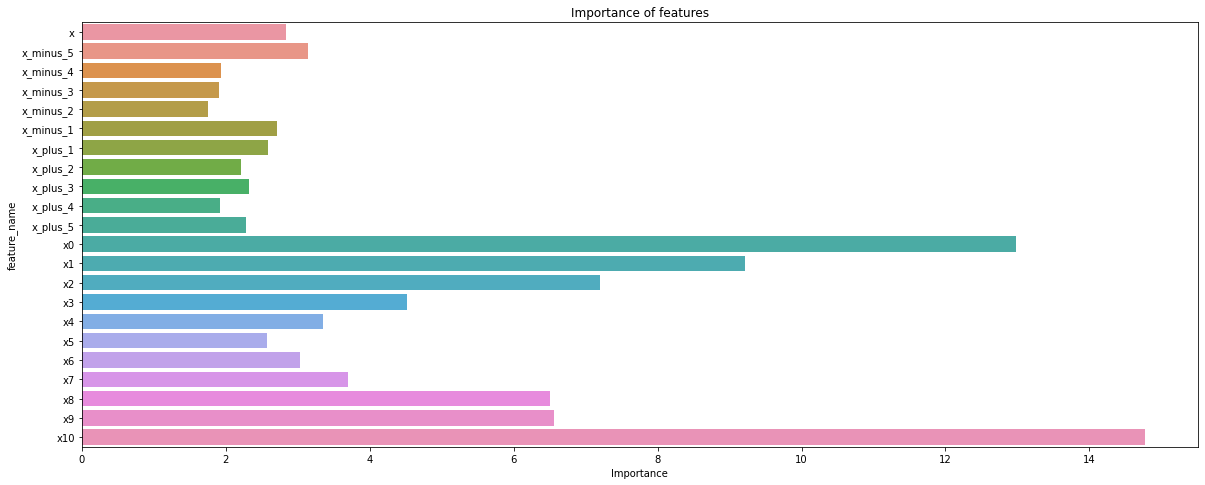

In [233]:
feature_importances = pd.DataFrame(zip(X_train.columns, catb_model2.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
sns.barplot(feature_importances['importance'], feature_importances['feature_name'])
    
plt.xlabel('Importance')
plt.title('Importance of features')
plt.show()

In [256]:
y_train_pred = catb_model2.predict(X_train)
y_test_pred = catb_model2.predict(X_valid)

In [257]:
y_test_pred2 = y_test_pred.copy()
y_train_pred2 = y_train_pred.copy()

In [258]:
y_test_pred2 = pd.Series(y_test_pred2, index=X_valid.index)
y_train_pred2 = pd.Series(y_train_pred2, index=X_train.index)

In [259]:
X_concat = pd.concat([X_valid['x'], X_train['x']])

In [260]:
y_pred_concat = pd.concat([y_test_pred2, y_train_pred2])

In [264]:
X_concat = X_concat.sort_index()
X_concat

0        0.928571
1        0.571429
2        0.785714
3        1.285714
4        1.000000
           ...   
60482   -2.000000
60483   -2.000000
60484   -2.000000
60485   -1.666667
60486   -2.000000
Name: x, Length: 60487, dtype: float64

In [266]:
y_pred_concat = y_pred_concat.sort_index()
y_pred_concat

0        0
1        0
2        0
3        0
4        0
        ..
60482    0
60483    0
60484    0
60485    0
60486    0
Length: 60487, dtype: int64

In [263]:
y

0        0
1        0
2        0
3        0
4        0
        ..
60482    0
60483    0
60484    0
60485    0
60486    0
Name: y, Length: 60487, dtype: int64

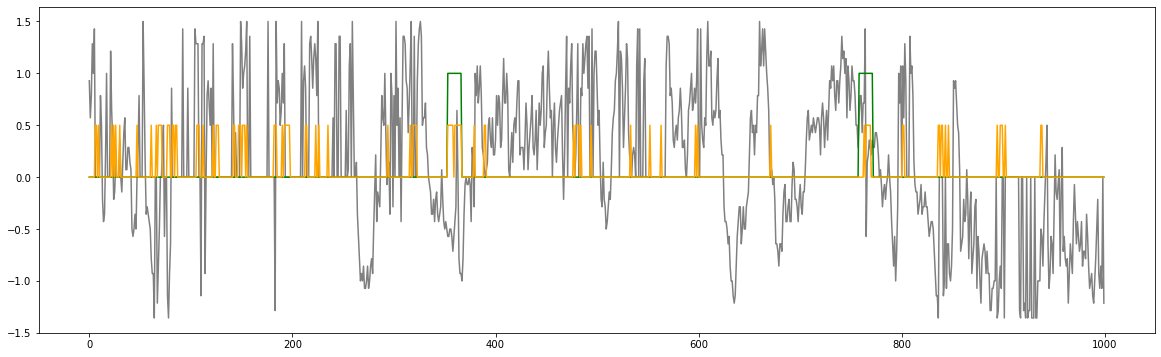

In [284]:
figure(figsize=(20,6))
plt.plot(X_concat.loc[X_concat.index < 1000], color='grey')
plt.plot(y.loc[y.index < 1000], color='green')
plt.plot(y_pred_concat.loc[y_pred_concat.index < 1000]/2, color='orange')
plt.show()

In [288]:
y.loc[y == 1].index < 1000

array([ True,  True,  True, ..., False, False, False])

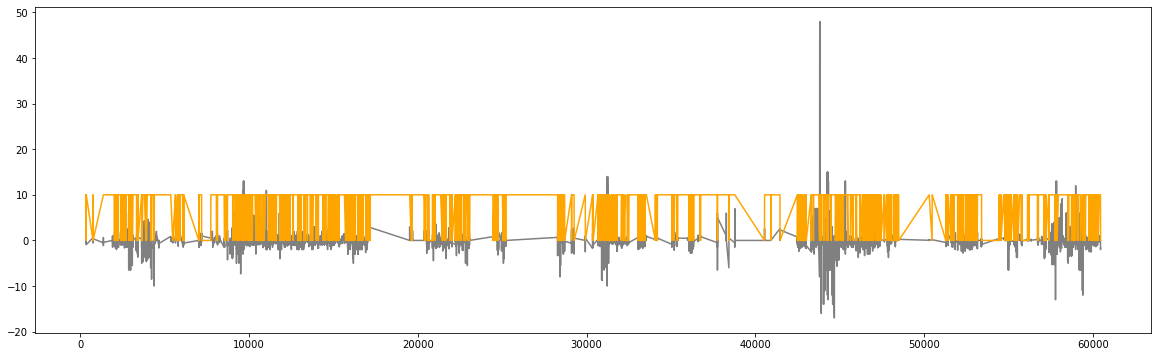

In [302]:
figure(figsize=(20,6))
plt.plot(X_concat.loc[y == 1], color='grey')
# plt.plot(y.loc[y == 1]*10, color='green')
plt.plot(y_pred_concat.loc[y == 1]*10, color='orange')
plt.show()

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [308]:
for idx in y_pred_concat.index:
    if idx == 0 or idx == y_pred_concat.index[-1]:
        y_pred_concat.loc[idx] = 0
    else:
        if y_pred_concat.loc[idx] == 1 and y_pred_concat.loc[idx - 1] == 0 and y_pred_concat.loc[idx + 1] == 0:
            y_pred_concat.loc[idx] = 0
            
y_pred_concat.loc[y_pred_concat == 1]

6        1
7        1
68       1
69       1
70       1
        ..
60427    1
60441    1
60442    1
60478    1
60479    1
Length: 16746, dtype: int64

In [309]:
y.loc[y == 1]

353      1
354      1
355      1
356      1
357      1
        ..
60445    1
60446    1
60447    1
60448    1
60449    1
Name: y, Length: 8961, dtype: int64

In [311]:
print('CONCAT\n\n' + classification_report(y, y_pred_concat))
print(pd.crosstab(y, y_pred_concat))

CONCAT

              precision    recall  f1-score   support

           0       0.97      0.83      0.89     51526
           1       0.46      0.87      0.60      8961

    accuracy                           0.83     60487
   macro avg       0.72      0.85      0.75     60487
weighted avg       0.90      0.83      0.85     60487

col_0      0     1
y                 
0      42539  8987
1       1202  7759


In [312]:
# 15-wide window, no preprocessing, no normalization
df = cs_master.drop(columns='time')

for sfx in range(14):
    if sfx < 7:
        column_name = 'x_minus_' + str(7 - sfx)
    else:
        column_name = 'x_plus_' + str(sfx - 6)
    df[column_name] = 0


for itm in cs_master['id'].unique():
    tmp = df.loc[df['id']==itm]
    
    for sfx in range(14):
        if sfx < 7:
            column_name = 'x_minus_' + str(7 - sfx)
        else:
            column_name = 'x_plus_' + str(sfx - 6)
        tmp[column_name] = 0
        for idx in tmp.index:
            if sfx < 7 and idx - tmp.index[0] >= 7 - sfx:
                tmp[column_name].loc[idx] = tmp['x'].loc[idx - 7 + sfx]
            elif sfx >= 7 and idx + sfx - 6 <= tmp.index[-1]:
                tmp[column_name].loc[idx] = tmp['x'].loc[idx + sfx - 6]
    df.loc[df['id']==itm] = tmp
df

id    x  y  x_minus_7  x_minus_6  x_minus_5  x_minus_4  x_minus_3  \
0        1  800  0          0          0          0          0          0   
1        1  780  0          0          0          0          0          0   
2        1  792  0          0          0          0          0          0   
3        1  820  0          0          0          0          0        800   
4        1  804  0          0          0          0        800        780   
...    ...  ... ..        ...        ...        ...        ...        ...   
60482  275  552  0        556        560        560        552        560   
60483  275  552  0        560        560        552        560        604   
60484  275  552  0        560        552        560        604        504   
60485  275  556  0        552        560        604        504        552   
60486  275  552  0        560        604        504        552        552   

       x_minus_2  x_minus_1  x_plus_1  x_plus_2  x_plus_3  x_plus_4  x_plus_5  \
0              0          0       780       792       820       804       828   
1              0        800       792       820       804       828       916   
2            800        780       820       804       828       916       960   
3            780        792       804       828       916       960       956   
4            792        820       828       916       960       956       928   
...          ...        ...       ...       ...       ...       ...       ...   
60482        604        504       552       552       556       552         0   
60483        504        552       552       556       552         0         0   
60484        552        552       556       552         0         0         0   
60485        552        552       552         0         0         0         0   
60486        552        556         0         0         0         0         0   

       x_plus_6  x_plus_7  
0           916       960  
1           960       956  
2           956       928  
3           928       836  
4           836       792  
...         ...       ...  
60482         0         0  
60483         0         0  
60484         0         0  
60485         0         0  
60486         0         0  

[60487 rows x 17 columns]

In [313]:
for itm in range(15):
    df['x' + str(itm)] = 0

In [314]:
window_column = ['x', 'x_minus_7', 'x_minus_6', 'x_minus_5', 'x_minus_4', 'x_minus_3', 'x_minus_2', 'x_minus_1',
                 'x_plus_1', 'x_plus_2', 'x_plus_3', 'x_plus_4', 'x_plus_5', 'x_plus_6', 'x_plus_7']

for row in df.index:
    res = []
    for column in window_column:
        res.append(df.loc[[row]][column].values[0])
    res.sort()
    for idx in range(len(res)):
        df['x' + str(idx)].loc[[row]] = res[idx]
df

id    x  y  x_minus_7  x_minus_6  x_minus_5  x_minus_4  x_minus_3  \
0        1  800  0          0          0          0          0          0   
1        1  780  0          0          0          0          0          0   
2        1  792  0          0          0          0          0          0   
3        1  820  0          0          0          0          0        800   
4        1  804  0          0          0          0        800        780   
...    ...  ... ..        ...        ...        ...        ...        ...   
60482  275  552  0        556        560        560        552        560   
60483  275  552  0        560        560        552        560        604   
60484  275  552  0        560        552        560        604        504   
60485  275  556  0        552        560        604        504        552   
60486  275  552  0        560        604        504        552        552   

       x_minus_2  x_minus_1  ...   x5   x6   x7   x8   x9  x10  x11  x12  x13  \
0              0          0  ...    0    0  780  792  800  804  820  828  916   
1              0        800  ...    0  780  792  800  804  820  828  916  956   
2            800        780  ...  780  792  800  804  820  828  916  928  956   
3            780        792  ...  792  800  804  820  828  836  916  928  956   
4            792        820  ...  792  800  804  820  828  836  916  928  956   
...          ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
60482        604        504  ...  552  552  552  552  556  556  560  560  560   
60483        504        552  ...  552  552  552  552  552  556  560  560  560   
60484        552        552  ...  504  552  552  552  552  552  556  560  560   
60485        552        552  ...    0  504  552  552  552  552  552  556  560   
60486        552        556  ...    0    0  504  552  552  552  552  556  560   

       x14  
0      960  
1      960  
2      960  
3      960  
4      960  
...    ...  
60482  604  
60483  604  
60484  604  
60485  604  
60486  604  

[60487 rows x 32 columns]

In [418]:
df_train = pd.DataFrame(columns=df.columns)
df_test = pd.DataFrame(columns=df.columns)
for itm in df['id'].unique():
    if itm%3 == 2:
        df_test = pd.concat([df_test, df.loc[df['id'] == itm]])
    else:
        df_train = pd.concat([df_train, df.loc[df['id'] == itm]])

In [419]:
df_train

id    x  y x_minus_7 x_minus_6 x_minus_5 x_minus_4 x_minus_3  \
0        1  800  0         0         0         0         0         0   
1        1  780  0         0         0         0         0         0   
2        1  792  0         0         0         0         0         0   
3        1  820  0         0         0         0         0       800   
4        1  804  0         0         0         0       800       780   
...    ...  ... ..       ...       ...       ...       ...       ...   
60282  273  620  0      1176       596       596       592       604   
60283  273  620  0       596       596       592       604       612   
60284  273  620  0       596       592       604       612       608   
60285  273  632  0       592       604       612       608       620   
60286  273  640  0       604       612       608       620       620   

      x_minus_2 x_minus_1  ...   x5   x6   x7   x8   x9  x10  x11  x12  x13  \
0             0         0  ...    0    0  780  792  800  804  820  828  916   
1             0       800  ...    0  780  792  800  804  820  828  916  956   
2           800       780  ...  780  792  800  804  820  828  916  928  956   
3           780       792  ...  792  800  804  820  828  836  916  928  956   
4           792       820  ...  792  800  804  820  828  836  916  928  956   
...         ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
60282       612       608  ...  596  604  608  612  620  620  620  632  640   
60283       608       620  ...  596  596  604  608  612  620  620  620  632   
60284       620       620  ...  592  596  604  608  612  620  620  620  632   
60285       620       620  ...    0  592  604  608  612  620  620  620  632   
60286       620       632  ...    0    0  604  608  612  620  620  620  632   

        x14  
0       960  
1       960  
2       960  
3       960  
4       960  
...     ...  
60282  1176  
60283   640  
60284   640  
60285   640  
60286   640  

[38830 rows x 32 columns]

In [420]:
df_test

id    x  y x_minus_7 x_minus_6 x_minus_5 x_minus_4 x_minus_3  \
1870     2  772  0         0         0         0         0         0   
1871     2  132  0         0         0         0         0         0   
1872     2  632  0         0         0         0         0         0   
1873     2  816  0         0         0         0         0       772   
1874     2  808  0         0         0         0       772       132   
...    ...  ... ..       ...       ...       ...       ...       ...   
60482  275  552  0       556       560       560       552       560   
60483  275  552  0       560       560       552       560       604   
60484  275  552  0       560       552       560       604       504   
60485  275  556  0       552       560       604       504       552   
60486  275  552  0       560       604       504       552       552   

      x_minus_2 x_minus_1  ...   x5   x6   x7   x8   x9  x10  x11  x12  x13  \
1870          0         0  ...    0    0  132  632  744  772  792  808  808   
1871          0       772  ...    0  132  632  744  772  784  792  808  808   
1872        772       132  ...  132  632  744  772  784  792  804  808  808   
1873        132       632  ...  632  744  772  772  784  792  804  808  808   
1874        632       816  ...  744  772  772  784  792  804  808  808  816   
...         ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
60482       604       504  ...  552  552  552  552  556  556  560  560  560   
60483       504       552  ...  552  552  552  552  552  556  560  560  560   
60484       552       552  ...  504  552  552  552  552  552  556  560  560   
60485       552       552  ...    0  504  552  552  552  552  552  556  560   
60486       552       556  ...    0    0  504  552  552  552  552  556  560   

       x14  
1870   816  
1871   816  
1872   816  
1873   816  
1874   820  
...    ...  
60482  604  
60483  604  
60484  604  
60485  604  
60486  604  

[21657 rows x 32 columns]

In [421]:
y_train = df_train['y']
y_train = y_train.astype(np.int64)
y_test = df_test['y']
y_test = y_test.astype(np.int64)

In [422]:
drop_columns = ['id', 'y', 'x_minus_7', 'x_minus_6', 'x_minus_5', 'x_minus_4', 
                'x_minus_3', 'x_minus_2', 'x_minus_1', 'x_plus_1', 'x_plus_2', 
                'x_plus_3', 'x_plus_4', 'x_plus_5', 'x_plus_6', 'x_plus_7']

In [423]:
df_train = df_train.drop(columns=drop_columns)
df_train = df_train.astype(np.int64)
df_train

x  x0  x1  x2   x3   x4   x5   x6   x7   x8   x9  x10  x11  x12  x13  \
0      800   0   0   0    0    0    0    0  780  792  800  804  820  828  916   
1      780   0   0   0    0    0    0  780  792  800  804  820  828  916  956   
2      792   0   0   0    0    0  780  792  800  804  820  828  916  928  956   
3      820   0   0   0    0  780  792  800  804  820  828  836  916  928  956   
4      804   0   0   0  780  792  792  800  804  820  828  836  916  928  956   
...    ...  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
60282  620   0   0   0  592  596  596  604  608  612  620  620  620  632  640   
60283  620   0   0   0    0  592  596  596  604  608  612  620  620  620  632   
60284  620   0   0   0    0    0  592  596  604  608  612  620  620  620  632   
60285  632   0   0   0    0    0    0  592  604  608  612  620  620  620  632   
60286  640   0   0   0    0    0    0    0  604  608  612  620  620  620  632   

        x14  
0       960  
1       960  
2       960  
3       960  
4       960  
...     ...  
60282  1176  
60283   640  
60284   640  
60285   640  
60286   640  

[38830 rows x 16 columns]

In [424]:
df_test = df_test.drop(columns=drop_columns)
df_test = df_test.astype(np.int64)
df_test

x  x0  x1  x2   x3   x4   x5   x6   x7   x8   x9  x10  x11  x12  x13  \
1870   772   0   0   0    0    0    0    0  132  632  744  772  792  808  808   
1871   132   0   0   0    0    0    0  132  632  744  772  784  792  808  808   
1872   632   0   0   0    0    0  132  632  744  772  784  792  804  808  808   
1873   816   0   0   0    0  132  632  744  772  772  784  792  804  808  808   
1874   808   0   0   0  132  632  744  772  772  784  792  804  808  808  816   
...    ...  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
60482  552   0   0   0  504  552  552  552  552  552  556  556  560  560  560   
60483  552   0   0   0    0  504  552  552  552  552  552  556  560  560  560   
60484  552   0   0   0    0    0  504  552  552  552  552  552  556  560  560   
60485  556   0   0   0    0    0    0  504  552  552  552  552  552  556  560   
60486  552   0   0   0    0    0    0    0  504  552  552  552  552  556  560   

       x14  
1870   816  
1871   816  
1872   816  
1873   816  
1874   820  
...    ...  
60482  604  
60483  604  
60484  604  
60485  604  
60486  604  

[21657 rows x 16 columns]

In [425]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

5.526050420168067

In [426]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'one_hot_max_size':15,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [427]:
y_train.isna().sum().sum()

0

In [447]:
catb_model3 = catb.CatBoostClassifier(**frozen_params, iterations=100, max_depth=9)
catb_model3.fit(df_train, y_train, plot=True, eval_set=(df_test, y_test))

evaluate_preds(catb_model3, df_train, df_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     32880
           1       0.48      0.92      0.63      5950

    accuracy                           0.84     38830
   macro avg       0.73      0.87      0.76     38830
weighted avg       0.91      0.84      0.85     38830

TEST

              precision    recall  f1-score   support

           0       0.97      0.78      0.86     18646
           1       0.38      0.83      0.52      3011

    accuracy                           0.79     21657
   macro avg       0.67      0.81      0.69     21657
weighted avg       0.88      0.79      0.82     21657

CONFUSION MATRIX

col_0      0     1
y                 
0      14580  4066
1        512  2499


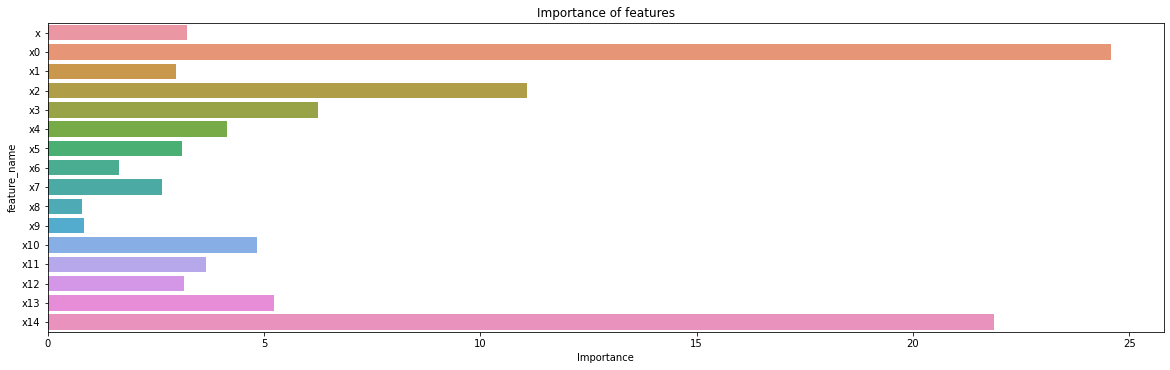

In [430]:
feature_importances = pd.DataFrame(zip(df_train.columns, catb_model3.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
sns.barplot(feature_importances['importance'], feature_importances['feature_name'])
    
plt.xlabel('Importance')
plt.title('Importance of features')
plt.show()

In [436]:
y_train_pred = pd.Series(catb_model3.predict(df_train), index=df_train.index)
y_test_pred = pd.Series(catb_model3.predict(df_test), index=df_test.index)

In [438]:
y_test_pred

1870     0
1871     0
1872     0
1873     0
1874     0
        ..
60482    0
60483    0
60484    0
60485    0
60486    0
Length: 21657, dtype: int64

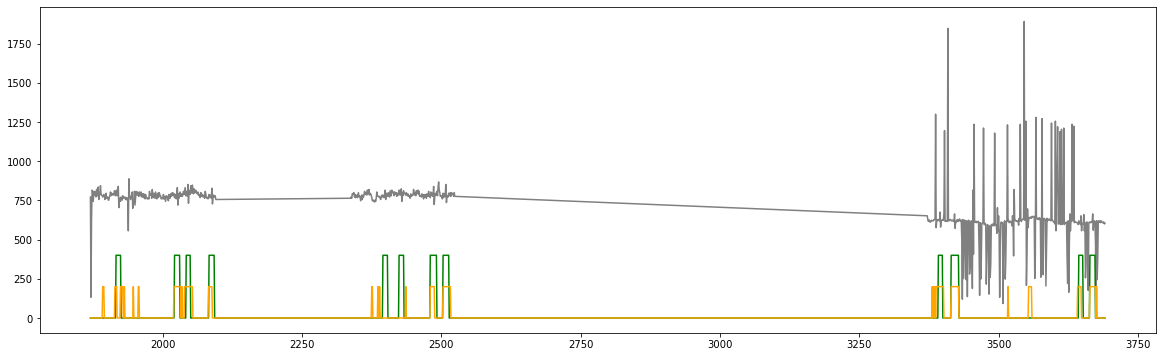

In [443]:
figure(figsize=(20,6))
plt.plot(df_test.loc[df_test.index < 4000, 'x'], color='grey')
plt.plot(y_test.loc[y_test.index < 4000]*400, color='green')
plt.plot(y_test_pred.loc[y_test_pred.index < 4000]*200, color='orange')
plt.show()

In [448]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [452]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

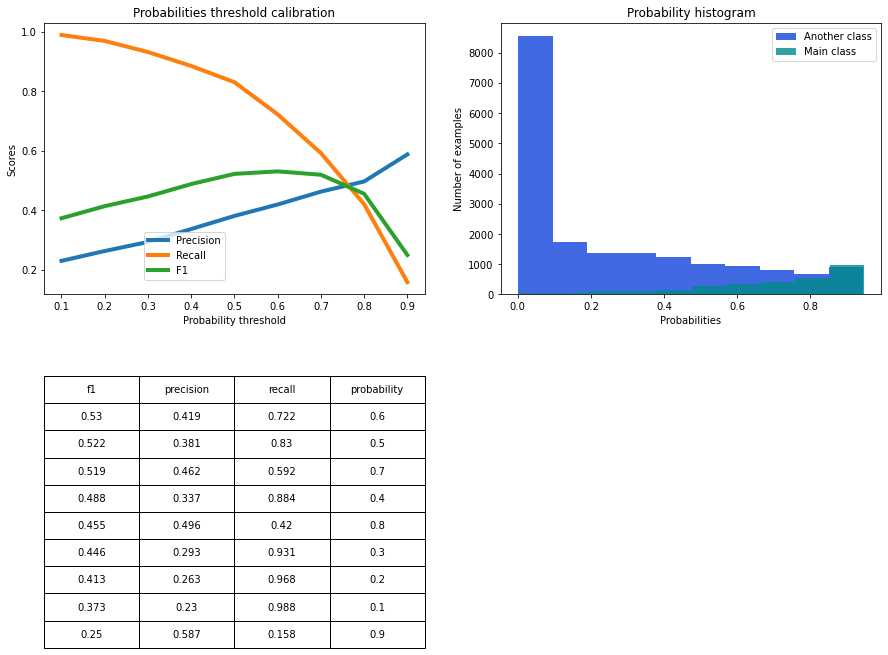

In [453]:
y_test_pred_probs = catb_model3.predict_proba(df_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)